In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
device = "cuda"

In [2]:
class config:
    model = "resnet18"
    batchsize = 32
    WEIGHT_DECAY = 0.01
    EPOCHS = 15
class path:
    maindir = "/kaggle/input/gsoclensing/dataset/train"
    valid = "/kaggle/input/gsoclensing/dataset/val"

In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from tqdm import tqdm
import timm
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
import time
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings


In [5]:
data = np.load('/kaggle/input/gsoclensing/dataset/train/no/5955.npy')

In [6]:
data.shape

(1, 150, 150)

In [7]:
train_data = {}
for i in (range(len(os.listdir(path.maindir)))):
    for j in tqdm(os.listdir(os.path.join(path.maindir,os.listdir(path.maindir)[i]))):
        train_data[os.path.join(os.path.join(path.maindir,os.listdir(path.maindir)[i],j))]=i
        
valid_data = {}
for i in (range(len(os.listdir(path.valid)))):
    for j in tqdm(os.listdir(os.path.join(path.valid,os.listdir(path.valid)[i]))):
        valid_data[os.path.join(os.path.join(path.valid,os.listdir(path.valid)[i],j))]=i


100%|██████████| 2500/2500 [00:00<00:00, 2578.81it/s]


In [8]:
imgtrans = transforms.Compose([
    transforms.ToPILImage(mode='L'),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
]
)

In [9]:
class CustomDataset():
    def __init__(self,dictt,trans):
        self.trans = trans
        self.dic = dictt
    def __len__(self):
        return len(self.dic)
    def __getitem__(self,idx):
        keys = list(self.dic)[idx]
        data = np.load(keys)
        data = torch.tensor(data)
        data = self.trans(data)
        values = list(self.dic.values())[idx]
        return {
            "data":torch.tensor(data,dtype = torch.float32),
            "value":torch.tensor(values)
        }

    
            

In [10]:
custom = CustomDataset(train_data,imgtrans)


In [11]:
len(custom)

30000

In [12]:
custom[0]["data"]

/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),


tensor([[[-0.9686, -0.9843, -0.9843,  ..., -0.9765, -0.9922, -0.9843],
         [-0.9765, -0.9843, -0.9686,  ..., -0.9765, -0.9843, -0.9765],
         [-0.9843, -0.9765, -0.9686,  ..., -0.9765, -0.9843, -0.9922],
         ...,
         [-0.9686, -0.9922, -0.9765,  ..., -0.9843, -0.9843, -0.9843],
         [-0.9765, -0.9922, -0.9843,  ..., -0.9922, -0.9765, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9843, -0.9922, -0.9686]]])

In [13]:
def deltamat(shape):
    kk = np.zeros((shape,shape))
    for i in range(shape):
        for j in range(shape):
            kk[i][j] = (((i+1)**2)+((j+1)**2))**0.5
    return torch.tensor(kk,dtype = torch.float32)
positiontensor = deltamat(224)
positiontensor.to("cuda")

tensor([[  1.4142,   2.2361,   3.1623,  ..., 222.0023, 223.0022, 224.0022],
        [  2.2361,   2.8284,   3.6056,  ..., 222.0090, 223.0090, 224.0089],
        [  3.1623,   3.6056,   4.2426,  ..., 222.0203, 223.0202, 224.0201],
        ...,
        [222.0023, 222.0090, 222.0203,  ..., 313.9554, 314.6633, 315.3728],
        [223.0022, 223.0090, 223.0202,  ..., 314.6633, 315.3696, 316.0775],
        [224.0022, 224.0089, 224.0201,  ..., 315.3728, 316.0775, 316.7838]],
       device='cuda:0')

In [14]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel,self).__init__()
        self.resnet = timm.create_model(
            config.model,
            pretrained = True,
            drop_rate = 0.1
        )
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(in_features=512, out_features=3, bias=True)
    def forward(self,x):
        x = self.resnet(x)
        return x
        

In [15]:
simple = SimpleModel()
print(simple)
xx = torch.randn(size=(1,1,224,224))
simple(xx)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

SimpleModel(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

tensor([[ 0.0666,  0.2595, -0.4343]], grad_fn=<AddmmBackward0>)

In [16]:
simple(custom[0]["data"].unsqueeze(0))

/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),


tensor([[ 0.1010,  0.2529, -0.4227]], grad_fn=<AddmmBackward0>)

In [17]:
traindataset = CustomDataset(train_data,imgtrans)
validdataset  =CustomDataset(valid_data,imgtrans)

trainloader = DataLoader(traindataset,batch_size = 32,shuffle = True)
testloader = DataLoader(validdataset,batch_size = 32,shuffle = True)


In [18]:
from torch.optim.lr_scheduler import OneCycleLR


In [19]:
def trainer(model,trainloader,optimizer,criterion,device):
    model.train()
    iterationloss = 0
    counter = 0
    for data in tqdm(trainloader):
        message = data['data'].to(device)
        target = data['value'].to(device).squeeze()
        optimizer.zero_grad()
        out = model(message)
        loss = criterion(F.log_softmax(out, dim=1), target)
        loss.backward()
        optimizer.step()
        iterationloss+=loss.item()*message.shape[0]
        counter+=message.shape[0]
    return iterationloss/counter

In [20]:
def tester(model, testloader, criterion, device):
    model.eval()
    iteration_loss = 0
    counter = 0
    correct_predictions = 0
    y_true = []
    y_scores = []

    for data in tqdm(testloader):
        message = data['data'].to(device)
        target = data['value'].to(device).squeeze()
        
        with torch.no_grad():
            out = model(message)
            loss = criterion(F.log_softmax(out, dim=1), target)
            iteration_loss += loss.item() * message.shape[0]
            
            predicted_classes = torch.argmax(F.log_softmax(out, dim=1), dim=1)
            correct_predictions += (predicted_classes == target).sum().item()
            
            # Append the labels and probabilities to the list
            y_true.extend(target.cpu().numpy())
            y_scores.extend(F.softmax(out, dim=1).cpu().numpy())  # Probabilities for each class

        counter += message.shape[0]

    accuracy = correct_predictions / counter
    print("Accuracy:", accuracy)
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Compute ROC AUC 
    roc_auc_scores = []
    false_positive_rate = dict()
    true_positive_rate = dict()
    for i in range(y_scores.shape[1]):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc_scores.append(roc_auc_score(y_true == i, y_scores[:, i]))

    # Computing average ROC AUC across all the classes by one vs all method and taking mean of the 3 classes
    roc_score = np.mean(roc_auc_scores)
    print("ROC AUC Score:", roc_score)
    
    plt.figure(figsize=(8, 6))
    class_dict = {0:"no substructure",1:"spherical substructure",2:"vortex substructure"}
    for i in range(y_scores.shape[1]):
        plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'Class {class_dict[i]} (ROC AUC = {roc_auc_scores[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    return iteration_loss / counter

In [21]:
meramodel = SimpleModel()
meramodel.to(device)
optimizer = torch.optim.RAdam(meramodel.parameters(),lr = 0.01)
criterion = nn.CrossEntropyLoss()
scheduler = scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-2,
        epochs=config.EPOCHS,
        steps_per_epoch=938,
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100)

Epoch no. = 1
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [01:09<00:00,  3.37it/s]


Accuracy: 0.3522666666666667
ROC AUC Score: 0.5290496266666667


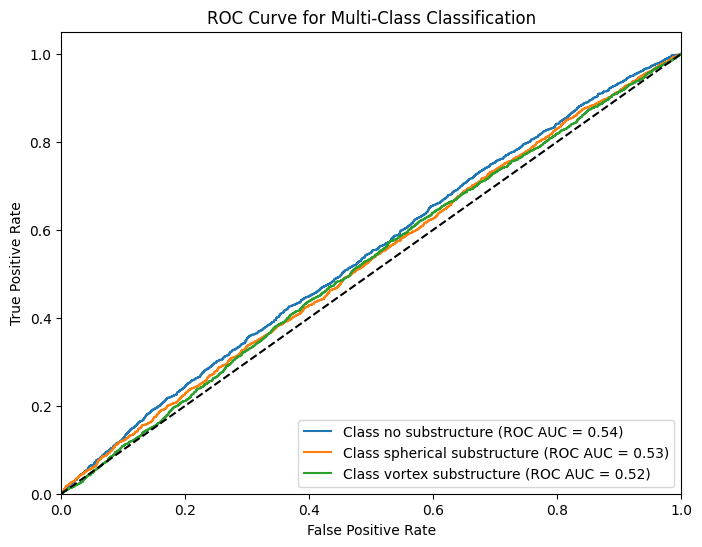

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  1.1013538405100505   ValidationLoss =  1.096130084292094
lr =  0.000400014396745375
Best Model Saved
Epoch no. = 2
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 16.69it/s]


Accuracy: 0.47533333333333333
ROC AUC Score: 0.6968026533333332


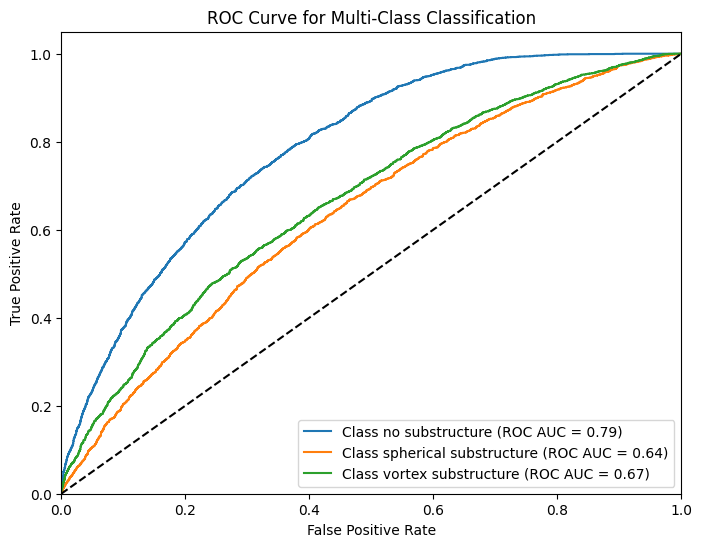

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  1.06967931877772   ValidationLoss =  0.9785515956878662
lr =  0.00040001147380941057
Best Model Saved
Epoch no. = 3
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 16.23it/s]


Accuracy: 0.6376
ROC AUC Score: 0.8397841199999999


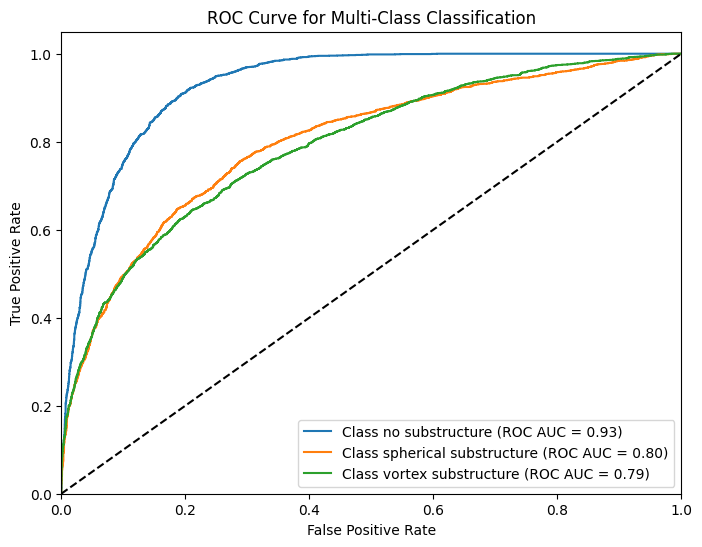

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.8305214680671692   ValidationLoss =  0.7827687753995259
lr =  0.00040000734187898256
Best Model Saved
Epoch no. = 4
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 16.48it/s]


Accuracy: 0.7768
ROC AUC Score: 0.9172222400000001


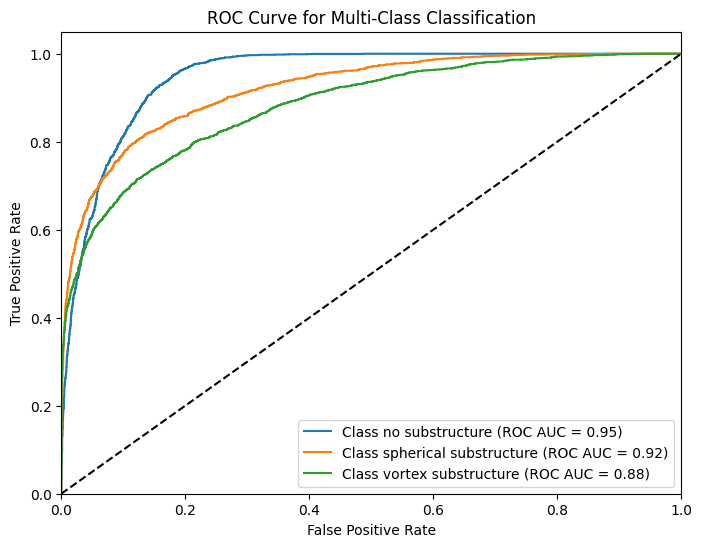

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.5917925765991211   ValidationLoss =  0.5325492792447408
lr =  0.00040000339828577015
Best Model Saved
Epoch no. = 5
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:15<00:00, 15.52it/s]


Accuracy: 0.8254666666666667
ROC AUC Score: 0.9443116800000001


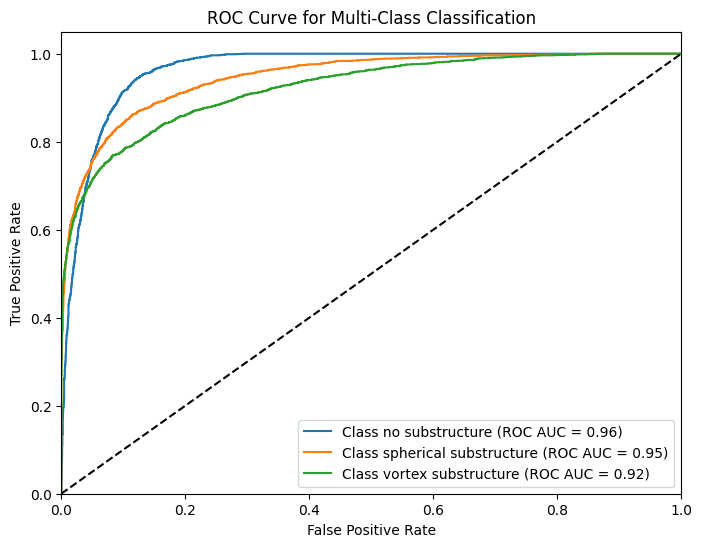

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.44191429483095807   ValidationLoss =  0.4388371740500132
lr =  0.0004000023075287993
Best Model Saved
Epoch no. = 6
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 16.51it/s]


Accuracy: 0.8481333333333333
ROC AUC Score: 0.95941716


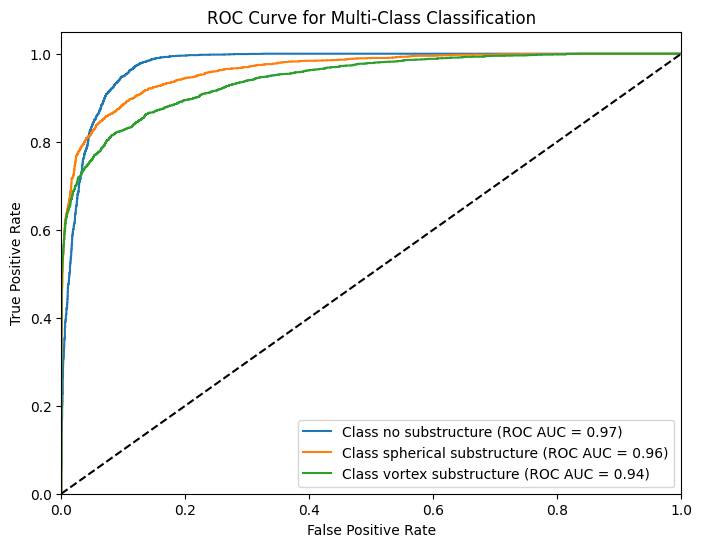

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.36539685002962746   ValidationLoss =  0.3906894458770752
lr =  0.0004000018289577658
Best Model Saved
Epoch no. = 7
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:13<00:00, 16.96it/s]


Accuracy: 0.7950666666666667
ROC AUC Score: 0.9525293066666666


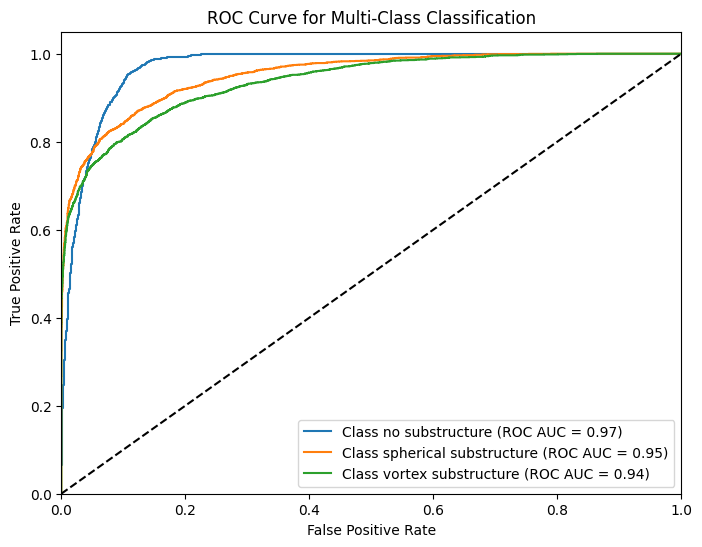

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.30637220770517987   ValidationLoss =  0.4797018222808838
lr =  0.0004000027572937763
Epoch no. = 8
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:15<00:00, 15.59it/s]


Accuracy: 0.8442666666666667
ROC AUC Score: 0.9618912533333334


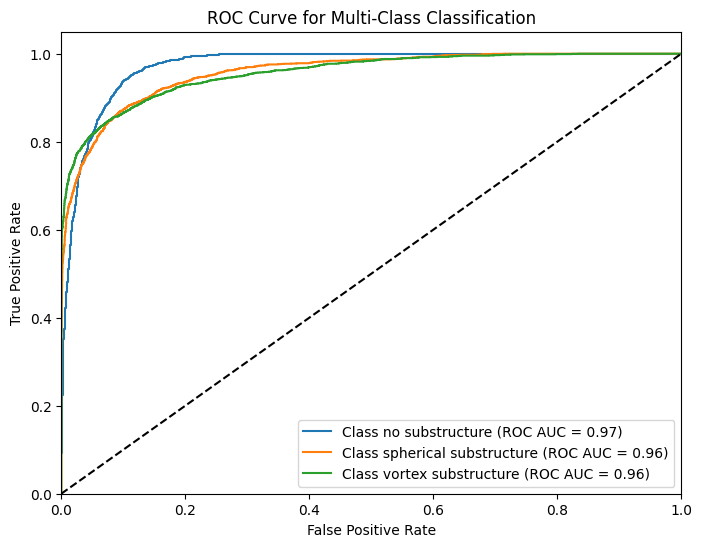

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.2636987323244413   ValidationLoss =  0.41117973732948304
lr =  0.0004000020258333875
Epoch no. = 9
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 15.91it/s]


Accuracy: 0.8873333333333333
ROC AUC Score: 0.9755238133333334


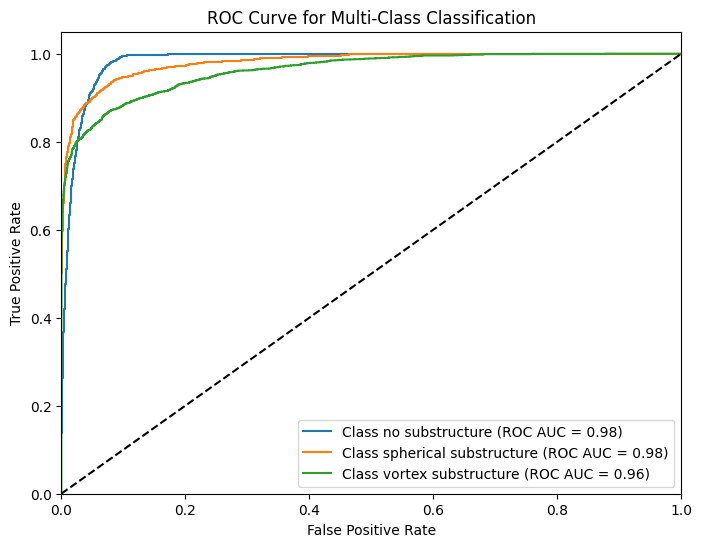

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.23631667220393818   ValidationLoss =  0.285429677939415
lr =  0.00040000097619951117
Best Model Saved
Epoch no. = 10
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:15<00:00, 15.57it/s]


Accuracy: 0.8106666666666666
ROC AUC Score: 0.9610120533333332


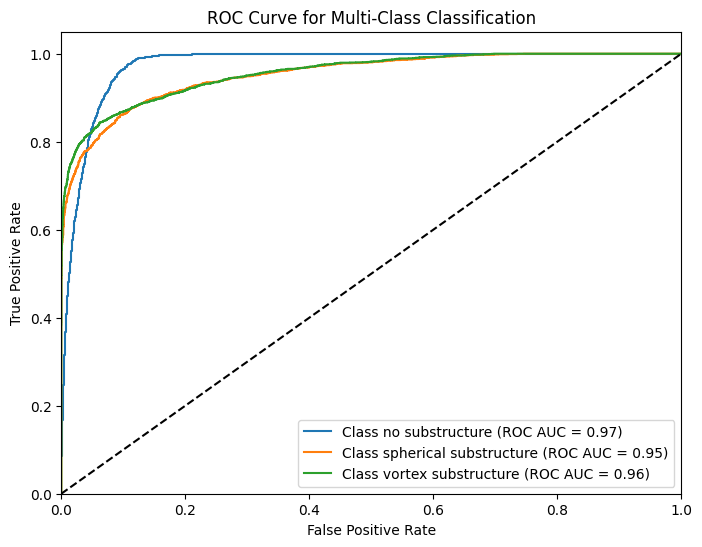

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.2056844084262848   ValidationLoss =  0.4801862329483032
lr =  0.0004000027628653074
Epoch no. = 11
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:19<00:00, 12.32it/s]


Accuracy: 0.8394666666666667
ROC AUC Score: 0.9665629466666665


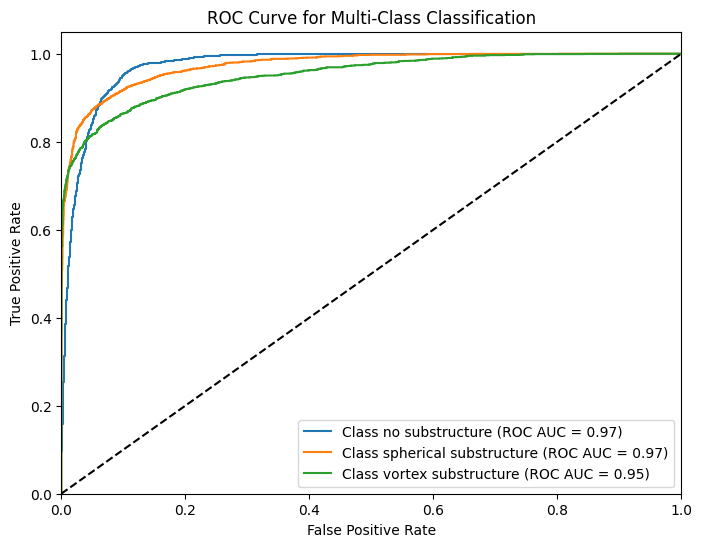

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.17931298339565596   ValidationLoss =  0.43938234090805056
lr =  0.00040000231326564085
Epoch no. = 12
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 16.57it/s]


Accuracy: 0.8872
ROC AUC Score: 0.9742783200000001


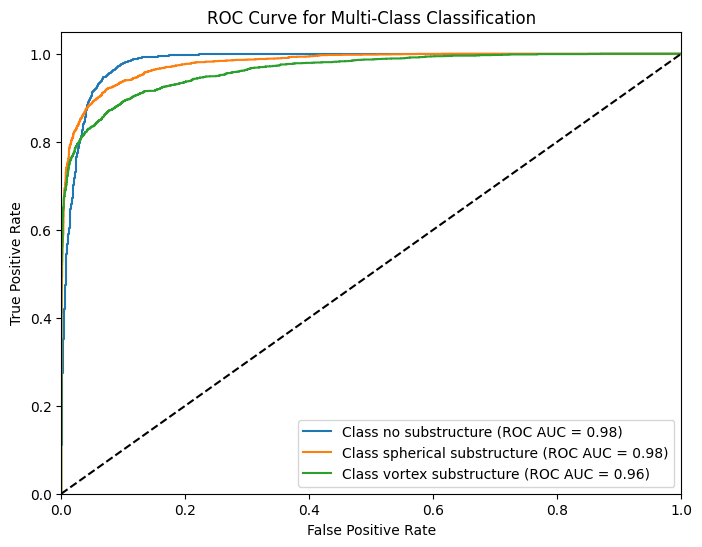

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.1647329296996196   ValidationLoss =  0.31034398620128634
lr =  0.0004000011540563012
Epoch no. = 13
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 16.07it/s]


Accuracy: 0.8773333333333333
ROC AUC Score: 0.9720721600000001


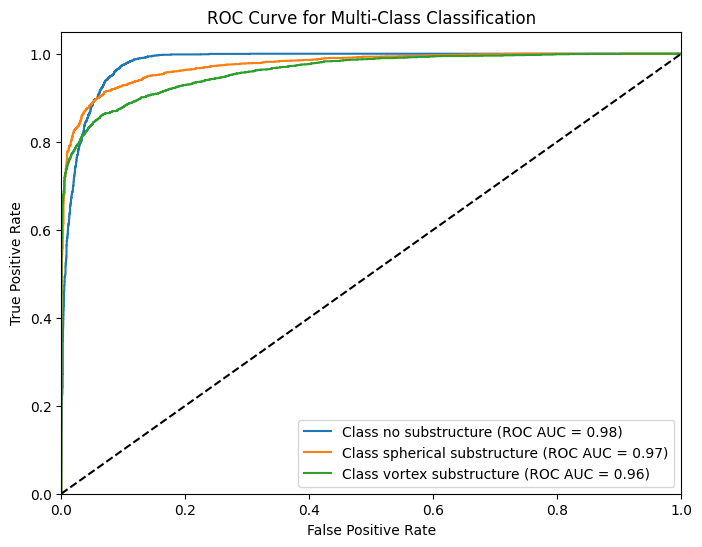

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.14297232034603755   ValidationLoss =  0.5045411358192563
lr =  0.00040000305023612723
Epoch no. = 14
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 16.01it/s]


Accuracy: 0.832
ROC AUC Score: 0.9635041066666666


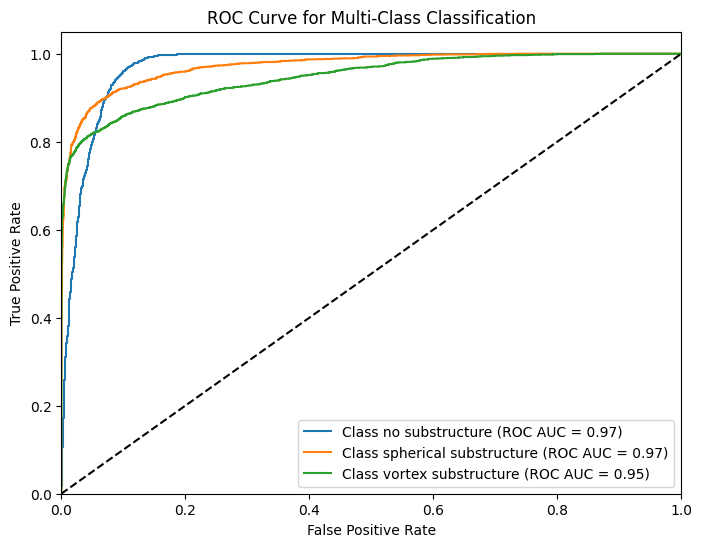

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainLoss =  0.1329975181857745   ValidationLoss =  0.475235432434082
lr =  0.00040000270618779574
Epoch no. = 15
--------------------------------------------------------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_25/3178738305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "data":torch.tensor(data,dtype = torch.float32),
100%|██████████| 235/235 [00:14<00:00, 16.37it/s]


Accuracy: 0.9058666666666667
ROC AUC Score: 0.9804784933333334


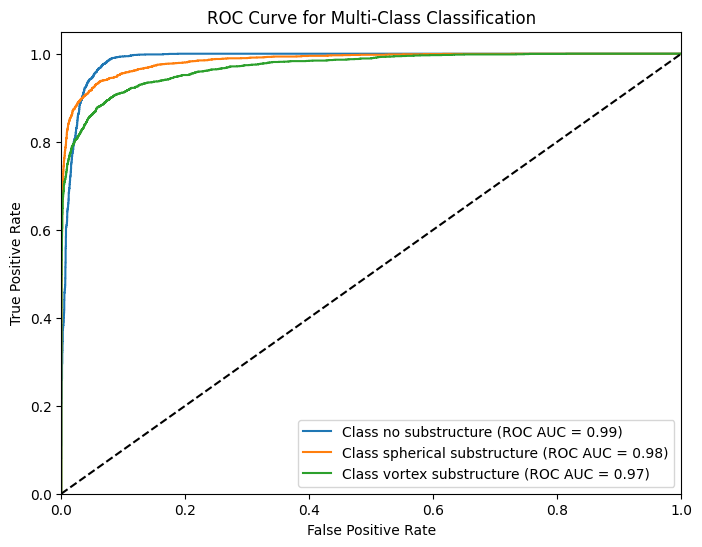

TrainLoss =  0.11749578869740168   ValidationLoss =  0.3134551697641611
lr =  0.00040000117731099974


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [22]:
trainloss =[]
valloss = []
bestloss = np.inf
for i in range(config.EPOCHS):
    print("Epoch no. =" ,i+1)
    print("-"*80)
    trainl = trainer(meramodel,trainloader,optimizer,criterion,device)
    vall = tester(meramodel,testloader,criterion,device)
    trainloss.append(trainl)
    valloss.append(vall)
    scheduler.step(vall)
    print("TrainLoss = ",trainl," ","ValidationLoss = ",vall)
    lr=scheduler.get_last_lr()[0]
    print("lr = ",lr)
    if bestloss>vall:
        bestloss = vall
        torch.save({
            'model':meramodel.state_dict(),
            'optimizer':optimizer.state_dict()},
        './Bestmodel.model'
        )
        print("Best Model Saved")
    print("="*80)